# Imports

In [1]:
# Imports
import pickle
import numpy as np
from matplotlib.pyplot import cm
from matplotlib import pyplot as plt
from matplotlib import patches
from copy import deepcopy
import plotly.graph_objects as go
from scipy.optimize import curve_fit
from dataclasses import make_dataclass

import sys
module_path = 'code' 
if module_path not in sys.path:
    sys.path.append(module_path)
    
np.set_printoptions(threshold=sys.maxsize)


# Markus's code
from MM_Plot_Utils import plot, hist
from MM_Maze_Utils import *
from MM_Traj_Utils import *

%matplotlib inline
%reload_ext autoreload
%autoreload 2

# Initialize Data

In [2]:
UnrewNames=['B5','B6','B7','D3','D4','D5','D6','D7','D8','D9']
RewNames=['B1','B2','B3','B4','C1','C3','C6','C7','C8','C9']
UnrewNamesSub=['B5','B6','B7','D3','D4','D5','D7','D8','D9'] # excluding D6 which barely entered the maze
AllNames=RewNames+UnrewNames

# Helper Functions

## Maze and Trajectories

In [3]:
def ModeMask(tf,ma,re):
    '''
    Creates an array that parallels the bouts in tf giving the behavioral mode for every state
    0=home,1=drink,2=explore
    '''
    cl=SplitModeClips(tf,ma,re=True) # split the trajectory into mode clips
    ex=[np.zeros(len(b)) for b in tf.no] # list of arrays, one for each bout
    for c in cl: # for each clip
        ex[c[0]][c[1]:c[1]+c[2]]=c[3] # mark the states in the clip with the mode
    return ex

In [4]:
def NewTransMatrix(ma):
    '''
    Add node 127 to trans matrix
    '''
    tra = TransMatrix(ma)
    tra = np.append(tra,[[-1,0,0]],axis=0)
    return tra

## Initialization

A **state** is a tuple $(sn,sd)$ where $sn$ is the number of the state node, and $sd$ is the direction from which we have arrived to the state, as follows:
* 0: from parent
* 1: from left
* 2: from right

An **action** is a number indicating the action, as follows:
* 0: parent
* 1: left
* 2: right

The actions in the original code are numbered:
* 0: left
* 1: right
* 2: parent

$TranslateAction$ converts the original action codes to our action codes.

The action is viewed by the code as from state $(sn,0)$, in order to translate it to the action appropriate for the direction, we use $(sd + a) \text{ mod } 3$.

In [5]:
def TranslateAction(action):
    '''
    Translate action from original action code to our action code
    '''
    if (action == -1):
        return -1
    else:
        return (action + 1) % 3

In [6]:
def ConvertNodesToStatesActions(da,sta,ma):
    '''
    Convert node sequence to (state,action) format
    da = node list
    sta = node child matrix
    ma = maze
    '''
    newda=[(0,da[1])]
    for i,node in enumerate(da[1:],1):
        prevnode = da[i-1]
        nextnode = 0
        if i < len(da)-1:
            nextnode = da[i+1]
            
        nst = TranslateAction(StepType2(node, nextnode, ma)) # step type from MM_Maze_Utils
        
        state = node
        action = nst
        newda.append((state,action))
        
    return newda

$E$ matrix built as:
```
[
    [ # i = node number
        parent, left, right
    ]
]
```

In [7]:
def GetValue(E,state,action):
    '''
    return E(s,a)
    action = 0 - parent, 1 - left, 2 - right
    '''
    return E[state][action]

In [8]:
def FlattenHist(hist):
    '''
    Flatten hist where hist is an array of tuples (state,action) and return only state nodes
    '''
    return [x[0] for x in hist]

In [9]:
def FlattenBHist(hist):
    '''
    flatten bhist and return list of only state nodes with different array of nodes for each beta
    '''
    fhist = []
    for brow in hist[:,-1]:
        rhist = []
        for row in brow:
            rhist.extend(FlattenHist(row))
        fhist.append(rhist)
    return fhist

## New Nodes Visited

In [10]:
# Code from NewNodesMerge3 in MM_Traj_Utils
def NewNodes(hist_states,le):
    '''
    calculate number of new nodes visited in window
    hist_states = matrix of history
    le = window length
    '''
    en=list(range(2**le-1,2**(le+1)-1)) # list of node numbers in level le
    
    ce=np.array(hist_states, dtype="object") # concatenate all the bouts, only the nodes, not the times
    ei=np.where(np.isin(ce,en))[0] # index of all the desired node states
    
    if len(ei)>0: # if there is at least one state
        cn=np.copy(ce[ei]) # only the desired nodes
        lc=len(cn) # number of desired nodes encountered
        c=np.array([2,3,6,10,18,32,56,100,180,320,560,1000,1800,3200,5600,10000]) # window width in nodes
        c=c[np.where(c<lc)] # use only those shorter than full length
        c=np.append(c,lc) # add full length as last value
        n=[np.average(np.array([len(set(cn[j:j+c1])) for j in range(0,lc-c1+1,(lc-c1)//(lc//c1)+1)])) for c1 in c]
            # average number of distinct nodes in slightly overlapping windows of size w 
    else:
        w=np.array([]); c=np.array([]); n=np.array([])
        
    wcn=[np.array([]),c,n]
    return wcn

## Cross-Entropy

Calculate cross-entropy between two policies by:
$$ -\frac{1}{|S|} \sum_{(s,a) \in \mathcal{S} \times \mathcal{A}} \pi_1(s,a) \log_2 \pi_2(s,a) $$
where $\mathcal{S}$ is the set of states (from 0 to 126), $\mathcal{A}$ is the set of actions for each state (from 0 to 2), and $\pi_1,\pi_2$ are two policies derived from two seperate simulations. 

In [11]:
def CalculateCrossEntropy2P(p1,p2):
    '''
    Calculate cross-entropy between two policies
    p1,p2 = two policies of the same shape SxA
    '''
    ce=-np.sum(p1 * np.log2(p2, out=np.zeros_like(p2), where=(p2!=0)))/np.shape(p1)[0]
    
    return ce

# Initialize Maze

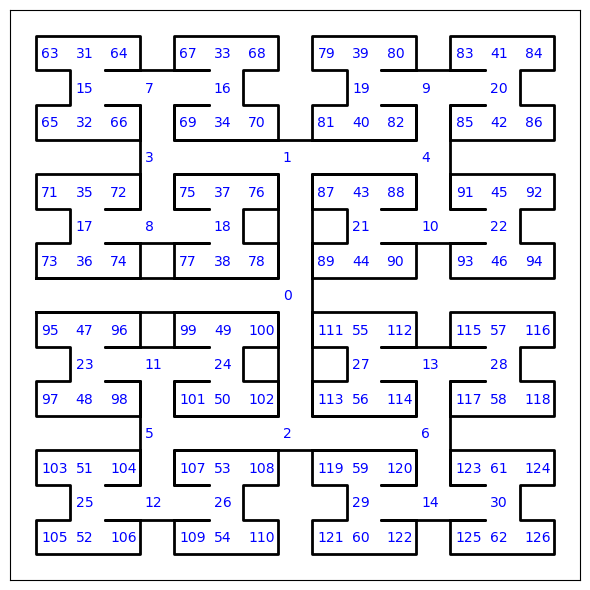

In [12]:
ma=NewMaze(6)
PlotMazeNodes(ma)

## Globals

In [13]:
terminals = np.arange(63,127)
terminal_mat = [1,0,0]
home_mat = [0,1/2,1/2]

# Main Functions

## Helpers

## Initialize

Policy defined as:

$$\pi(a|s) = \frac{e^{\beta E(s,a)}}{\sum_{a'}e^{\beta E(s,a')}}$$

$policy$ matrix shape is the same as E matrix shape (above).

$sta$ built as:
```
[
    [ # i = node number
        # node level (127 = home, 0 = 1,2 etc.)
        # left child node number
        # right child node number
    ]
]
```

In [371]:
NewTransMatrix(ma) # = sta

array([[127,   1,   2],
       [  0,   3,   4],
       [  0,   6,   5],
       [  1,   8,   7],
       [  1,   9,  10],
       [  2,  12,  11],
       [  2,  13,  14],
       [  3,  15,  16],
       [  3,  18,  17],
       [  4,  19,  20],
       [  4,  22,  21],
       [  5,  23,  24],
       [  5,  26,  25],
       [  6,  27,  28],
       [  6,  30,  29],
       [  7,  32,  31],
       [  7,  33,  34],
       [  8,  36,  35],
       [  8,  37,  38],
       [  9,  40,  39],
       [  9,  41,  42],
       [ 10,  44,  43],
       [ 10,  45,  46],
       [ 11,  48,  47],
       [ 11,  49,  50],
       [ 12,  52,  51],
       [ 12,  53,  54],
       [ 13,  56,  55],
       [ 13,  57,  58],
       [ 14,  60,  59],
       [ 14,  61,  62],
       [ 15,  63,  64],
       [ 15,  66,  65],
       [ 16,  67,  68],
       [ 16,  70,  69],
       [ 17,  71,  72],
       [ 17,  74,  73],
       [ 18,  75,  76],
       [ 18,  78,  77],
       [ 19,  79,  80],
       [ 19,  82,  81],
       [ 20,  83

In [14]:
def Init(beta):
    '''
    initialize simulation, return E and policy matrix, and sta = matrix of nodes and their children.
    '''
    sta=NewTransMatrix(ma) # array of nodes connected to each node as such: index = parent node, [level, left child, right child]
    E=np.ones((len(ma.ru)+1,3)) # 2D array of values
    policy = np.full(E.shape,1/3)
    policy[terminals] = terminal_mat # reset terminal matrices
    policy[-1] = home_mat # reset home matrix
    return E,policy,sta

## Simulation Functions

Update E by:
$$ E(s,a) \leftarrow E(s,a) + \eta \left(-E(s,a) + \gamma E(s',a')\right) $$

In [15]:
def UpdateEAndPolicy(E,policy,state0,action0,value1,beta,gamma,eta):
    '''
    Updates the E and policy matrix. If beta > 700, assume beta=infinity
    state0 = node
    action0 = 0 - parent, 1 - left, 2 - right
    value1 = E(s',a')
    '''
    value0 = GetValue(E,state0,action0) # get E(s,a)
    E[state0][action0] += eta * (-value0 + gamma * value1) # update E(s,a)
    # update policy
    if beta <= 700:
        exp_beta_E=np.exp(E * beta)
        policy=np.divide(exp_beta_E, exp_beta_E.sum(axis=1,keepdims=True), out=np.zeros_like(exp_beta_E), where=exp_beta_E.sum(axis=1,keepdims=True)!=0)
        policy[terminals] = terminal_mat # reset terminal matrices
        policy[-1] = home_mat # reset home matrix
    else: # beta = infinity
        m = max(E[state0])
        mi = np.where(E[state0] == m)[0]
        policy[state0,:] = 0
        policy[state0][mi] = 1/len(mi)
    
    return E,policy

In [16]:
def ChooseAction(policy,state):
    '''
    choose next action by policy probabilities. returns **translated action**
    '''
    return int(np.random.choice(3,1,p=policy[state])[0])

Cross-Entropy estimation for unknown source distribution calculated by:

$$ -\frac{1}{n} \sum_{i=1}^{n} \log_2 \pi(a_i | s_i) = \left\langle -\log_2 \pi(a_i | s_i) \right\rangle_i $$

where $n$ is the number of steps where $\pi(a_i | s_i) \neq 0$ and $\pi$ is the policy derived from the simulation.

In [17]:
def CalculateCrossEntropy(da,mk,E,pr,beta,gamma,eta,sta,ma):
    '''
    Calculate cross-entropy
    da = data
    mk = mask applied to action, Boolean
    pr = probability array
    sta = node child matrix
    ma = maze
    '''
    #ac=np.array([-1]+[StepType2(da[j-1],da[j],ma) for j in range(1,len(da))]) # forward actions
    acst = ConvertNodesToStatesActions(da,sta,ma)
    
    pt=[] # predicted probabilities for the observed action
    for i in range(len(da)): # i points to the action to be predicted
        if mk[i]:
            x = acst[i]
            sn = x[0]
            a = x[1]
            pt+=[pr[sn][a]] # add probability for the observed action to the list
            if i+1 < len(da) and mk[i+1]:
                x1 = acst[i+1]
                sn1 = x1[0]
                a1 = x1[1]
                value1 = GetValue(E,sn1,a1)
                E,pr = UpdateEAndPolicy(E,pr,sn,a,value1,beta,gamma,eta)
    
    pt = np.array(pt)
    #print(pt)
    #pts = pt[pt!=0] # pt support
    #print(pts)
    #ce=-np.sum(np.log2(pts))/len(pts) # cross-entropy
    ce=-np.sum(np.log2(pt, out=-np.ones_like(pt), where=(pt!=0)))/len(pt) # cross-entropy
    
    return ce

$hist$ matrix built as:
```
[
    [ # i = number of bout
        (state, ta)
    ]
]
```
With $state=(sn,sd)$ and $ta$ is the translated action.

In [18]:
def Simulate(nbouts,E,policy,sta,beta=0.1,gamma=0.1,eta=0.1):
    '''
    simulate trajectories and return final E and policy matrices, and history
    nbouts = number of bouts (exploration until back to cage)
    E = E matrix
    policy = policy matrix
    sta = parents and children matrix
    '''
    hist = []
    state0 = 0
    action0 = ChooseAction(policy,state0)
    for i in range(nbouts):
        hist.append([])
        home = False # has the bout ended
        hist[i].append((state0,action0))
        while not home:
            state1 = sta[state0][action0] # state1 = next state node
            action1 = ChooseAction(policy,state1)
            value1 = GetValue(E,state1,action1) # get E(s',a')
            E,policy = UpdateEAndPolicy(E,policy,state0,action0,value1,beta,gamma,eta)
            state0 = state1
            action0 = action1
            if state1 == 127: # back to cage
                home = True
            else:
                hist[i].append((state0,action0))
            
    return E, policy, hist

# End Nodes Visited

## Run Simulation

In [19]:
eta=0.1
gamma=0.1
betas = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 100]

nbouts = 100

bhist = np.ndarray(shape=(len(betas),2), dtype=object)
bhist[:,0] = betas

for j,beta in enumerate(betas): # run simulation on each beta
    E,policy,sta = Init(beta)
    E,policy,hist = Simulate(nbouts,E,policy,sta,beta,gamma,eta)
    bhist[j,-1] = hist

KeyboardInterrupt: 

## Play With Beta=100

In [281]:
# BETA = 100

nbouts = 100
beta=800
betas[-1] = 'infinity'
bhist[:,0] = betas
E,policy,sta = Init(beta)
E,policy,hist = Simulate(nbouts,E,policy,sta,beta,gamma,eta)
bhist[-1,-1] = hist


In [147]:
_,_,hist = Simulate(1,E,policy,sta,beta,gamma,eta)
print(policy)

[[0.55462541 0.22683901 0.21853558]
 [0.34804536 0.3291838  0.32277084]
 [0.33801774 0.32727089 0.33471137]
 [0.32445293 0.32325113 0.35229594]
 [0.32160377 0.34189406 0.33650217]
 [0.30788552 0.35460923 0.33750525]
 [0.33735481 0.3289042  0.33374099]
 [0.31345997 0.32615045 0.36038959]
 [0.34317467 0.33238474 0.3244406 ]
 [0.33385433 0.34076219 0.32538349]
 [0.33497892 0.3456816  0.31933948]
 [0.33372383 0.31772655 0.34854962]
 [0.34772317 0.32196056 0.33031627]
 [0.33410475 0.33842395 0.3274713 ]
 [0.33583358 0.3319132  0.33225322]
 [0.35207155 0.32774405 0.32018441]
 [0.3440487  0.31235993 0.34359137]
 [0.33082903 0.34188061 0.32729036]
 [0.331324   0.33241088 0.33626512]
 [0.31784803 0.35380991 0.32834206]
 [0.33530142 0.33004288 0.3346557 ]
 [0.33052051 0.34182378 0.32765571]
 [0.3319376  0.33187608 0.33618632]
 [0.32900135 0.32881274 0.34218592]
 [0.30888116 0.36133888 0.32977996]
 [0.30346172 0.32392105 0.37261723]
 [0.33208745 0.31204351 0.35586904]
 [0.31981966 0.36143567 0.31

## Plot End Nodes Visited

(1, 5000)

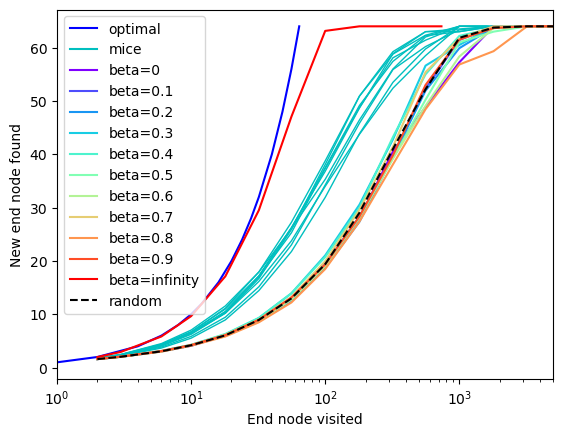

In [282]:
le=6 # end nodes level

# PLOT OPTIMAL
x=[1,2,4,6,8,10,12,16,20,24,28,32,40,48,56,64]
y=[1,2,4,6,8,10,12,16,20,24,28,32,40,48,56,64] 
fig, ax = plt.subplots()
ax.set_xscale('log')
ax.plot(x,y,'-b',label='optimal')

# PLOT UNREWARDED MICE
for i,nickname in enumerate(UnrewNamesSub):
    with open('outdata/'+nickname+'-Modes1', 'rb') as f:
        nn1,nf1,tr1,wcn=pickle.load(f)
    x=wcn[1,:]
    y=wcn[2,:]
    ax.plot(x,y,'-c',linewidth=1)
plt.plot([], [], 'c', label="mice")

# PLOT SIMULATION
fhist = FlattenBHist(bhist) # flattened bhist
color = cm.rainbow(np.linspace(0, 1, len(betas)))

for i,row in enumerate(fhist):
    wcn = NewNodes(row,le)
    x=wcn[1]
    y=wcn[2]
    ax.plot(x,y,c=color[i], label='beta=' + str(bhist[i,0]))
    
# PLOT RANDOM
tf=LoadTraj('rw01-tf')
wcn=NewNodesMerge3(tf,ma,le)
x=wcn[1,:]
y=wcn[2,:]
ax.plot(x,y,'--k', linewidth=1.5,label='random')

ax.legend()
ax.set_xlabel('End node visited')
ax.set_ylabel('New end node found')
ax.set_xlim([1,5000])


# Cross-Entropy

## Calculate cross-entropy for each unrewarded mouse

In [28]:
eta=0.1
gamma=0.1
beta=100
nbouts=100


#E,policy,hist = Simulate(nbouts,E,policy,sta,beta,gamma,eta)

In [291]:
print(policy)

[[0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1.

In [20]:
def SimulateCrossEntropy(Names,beta,gamma,eta,ma):
    unrew_ce=[]
    for nickname in Names:
        E,policy,sta = Init(beta)
        tf=LoadTraj(nickname+'-tf')
        ex=ModeMask(tf,ma,rew) # one array for each bout marking states with mode = 0,1,2
        dte=np.concatenate([b[:-2,0] for b in tf.no]) # test states
        mte=np.array([False]+[True,]*(len(dte)-1)) # mask for testing, all actions OK except first
        mte[np.where(dte[:-1]>62)[0]]=False # mask for testing, eliminate end nodes
        ce = CalculateCrossEntropy(dte,mte,E,policy,beta,gamma,eta,sta,ma)
        unrew_ce.append(ce)
    
    return unrew_ce

In [26]:
rew=False

beta=100
gamma=0.000
eta=0.000
ce = SimulateCrossEntropy(UnrewNamesSub,beta,gamma,eta,ma)
print(ce)

[1.5849625007211567, 1.5849625007211567, 1.5849625007211567, 1.5849625007211567, 1.5849625007211563, 1.5849625007211567, 1.5849625007211567, 1.5849625007211565, 1.5849625007211567]


In [21]:
rew = False

etas = np.linspace(0.1,1,9, endpoint=False)
gammas = np.linspace(0,1,10,endpoint=False)
betas = np.logspace(0.1,2,10,endpoint=False)
unified_unrew_ce_smallb = np.zeros((len(betas),len(gammas),len(etas),len(UnrewNamesSub)))
for b,beta in enumerate(betas):
    for g,gamma in enumerate(gammas):
        for e,eta in enumerate(etas):
            print(beta, gamma, eta)
            ce = SimulateCrossEntropy(UnrewNamesSub,beta,gamma,eta,ma)
            unified_unrew_ce_smallb[b,g,e]=ce
            print(ce)
            
print(unified_unrew_ce_smallb)

1.2589254117941673 0.0 0.1
[1.7607251944862685, 1.792963256335739, 1.7713968352872527, 1.7490403729191835, 1.7682193132895572, 1.7661487834495475, 1.7800372461642218, 1.737429473654476, 1.7481714941561706]
1.2589254117941673 0.0 0.2
[1.7723763421869092, 1.8037569766484245, 1.785728503283229, 1.7664513833236832, 1.7803498439317933, 1.7746171145924303, 1.7856276518142093, 1.749338258679157, 1.759653603236533]
1.2589254117941673 0.0 0.30000000000000004
[1.7770915543689927, 1.8079038775482623, 1.7919200535192148, 1.7726806150796508, 1.784634231892115, 1.77760793106375, 1.7880894880359146, 1.7536543947555245, 1.7643973254728837]
1.2589254117941673 0.0 0.4
[1.7797166852184996, 1.810099058350968, 1.7953779557875347, 1.7758888909407458, 1.7867725296944026, 1.7792907850559472, 1.7895294236332984, 1.7557729340360844, 1.767096401509737]
1.2589254117941673 0.0 0.5
[1.78141717382444, 1.8114803539305426, 1.7976088111342559, 1.7779095452514158, 1.7880812563327482, 1.780444847428445, 1.790493953734772

[1.7665620619269093, 1.7988143726374048, 1.7844529150235677, 1.7672122366119554, 1.7744750144221444, 1.7680229694211358, 1.781477277889571, 1.739959072054845, 1.7564655422903523]
1.2589254117941673 0.4 0.5
[1.7697549073800471, 1.8015385478530557, 1.788672590531796, 1.7712265053058134, 1.7776488334865184, 1.770645279007171, 1.784015490346075, 1.74312129376908, 1.7602166412457534]
1.2589254117941673 0.4 0.6
[1.7722769241495693, 1.8035859679019972, 1.7919921920368076, 1.7743338269985003, 1.7801946258519108, 1.7728410508657366, 1.7861355515785318, 1.7455136543317535, 1.763163881871512]
1.2589254117941673 0.4 0.7000000000000001
[1.7744479329876537, 1.8052823767284731, 1.7948323035886582, 1.776978164942161, 1.7824461364966115, 1.77482590156532, 1.7880392088573864, 1.7475139351101734, 1.7656637576856258]
1.2589254117941673 0.4 0.8
[1.7764567339296318, 1.8068130544404764, 1.7974363515501994, 1.779404190238271, 1.7845853733363315, 1.7767207179586264, 1.7898451852215556, 1.7493424245529094, 1.76

[1.7189734338009683, 1.7488496951596422, 1.737274768819718, 1.7263856306100516, 1.7234786631685812, 1.7143226847273838, 1.7342867780675233, 1.6837351376863932, 1.715478044498955]
1.2589254117941673 0.8 0.7000000000000001
[1.7236386876836969, 1.7528663285835993, 1.742755761629125, 1.7315608387634915, 1.7277463551909256, 1.718134983387194, 1.7385470537049328, 1.6874490004588278, 1.7205292665845597]
1.2589254117941673 0.8 0.8
[1.7285770911731138, 1.7570229259035295, 1.7485328655635217, 1.7368027146831158, 1.7323093959280313, 1.7222584650755768, 1.7430426606633018, 1.6912210521223554, 1.7256245839888436]
1.2589254117941673 0.8 0.9
[1.734320172709586, 1.7619798218811797, 1.7552432159475595, 1.7426626259419473, 1.7376633701613045, 1.7271365024851337, 1.748134083229852, 1.6954844990109412, 1.731310192610978]
1.2589254117941673 0.9 0.1
[1.6301113220102634, 1.6495252885070615, 1.6342168872062879, 1.6270518272490804, 1.6340570366344083, 1.630591487217607, 1.6466581222184076, 1.6115720435993528, 

[1.8779823187805735, 1.9291708327051649, 1.8901792084444886, 1.8516962410044033, 1.8871376356691911, 1.8898565550436024, 1.9149839831125863, 1.837380626714186, 1.8599533326739273]
1.9498445997580456 0.30000000000000004 0.2
[1.9088129099908784, 1.9580098094172258, 1.9268795715521607, 1.8954160672280704, 1.9192686737798175, 1.9158012946290675, 1.9355216421894432, 1.8719207013979695, 1.8912852904940158]
1.9498445997580456 0.30000000000000004 0.30000000000000004
[1.9215210639278408, 1.969916401370701, 1.9432132878654782, 1.9127419257618983, 1.9319861311915658, 1.9256073812738819, 1.9442927550888531, 1.8858926751404004, 1.9050177022502068]
1.9498445997580456 0.30000000000000004 0.4
[1.9288982530412786, 1.9765766637693696, 1.9530302919425275, 1.9223668147368642, 1.9391476493722934, 1.9314159879105297, 1.949689785513096, 1.8936050453229964, 1.913306055371523]
1.9498445997580456 0.30000000000000004 0.5
[1.9339827469975395, 1.9809937120327232, 1.9598540273564216, 1.928818769215493, 1.9440628394

[1.8509178829118114, 1.899801897201441, 1.8723497823883204, 1.849605038095133, 1.8609940614744998, 1.8522611804859581, 1.881027427744719, 1.79897042090489, 1.838877770346661]
1.9498445997580456 0.7000000000000001 0.4
[1.863986258250544, 1.9127381219138033, 1.8885582214125418, 1.8665808943173772, 1.8737932368562973, 1.8631448788835943, 1.892009544677663, 1.812445077913852, 1.8542188898799303]
1.9498445997580456 0.7000000000000001 0.5
[1.873925881401267, 1.9221205310337104, 1.9008339976127064, 1.8790583623607935, 1.8834747330748824, 1.8716324255085615, 1.900764139014638, 1.8223052558003205, 1.8657759733741586]
1.9498445997580456 0.7000000000000001 0.6
[1.8825177339181702, 1.9298910621211014, 1.9112739992610763, 1.8894474046742546, 1.8918732305903732, 1.8791895186192753, 1.9085842427865474, 1.83046254028059, 1.8754471445221024]
1.9498445997580456 0.7000000000000001 0.7000000000000001
[1.890701966265387, 1.9371039407564672, 1.9210711295598504, 1.898976258059872, 1.8999380036220768, 1.88655

[2.2403383016514518, 2.3069324995400424, 2.275422623676455, 2.2191126472759986, 2.2499431353775514, 2.23864290228252, 2.2606009531763886, 2.1956900217731037, 2.215888347684796]
3.019951720402016 0.1 0.7000000000000001
[2.2441878819349017, 2.3102312617218654, 2.28078491217844, 2.2240066544743984, 2.253451114603342, 2.2418397339338103, 2.263408621186841, 2.199031695293396, 2.2199392205167916]
3.019951720402016 0.1 0.8
[2.2474629662675194, 2.3130348780409586, 2.2853719533863277, 2.228204327040597, 2.2565421359516544, 2.244598806712207, 2.2658457747268472, 2.201922975026509, 2.2233691670152935]
3.019951720402016 0.1 0.9
[2.2504160066127312, 2.315573259662206, 2.289496627328826, 2.232033143513226, 2.259419477752619, 2.247098183827309, 2.2680773660076383, 2.2046301549479823, 2.2264513989059296]
3.019951720402016 0.2 0.1
[2.1395786522244364, 2.215421206626001, 2.1518828311644214, 2.0857764033652857, 2.151900507852374, 2.1591566656033034, 2.19484433731929, 2.085604748519522, 2.112801841348143]

[2.0156131973421356, 2.0938489587002493, 2.024122207129596, 1.9637313969113768, 2.0286699152211645, 2.034698532065641, 2.086395066931875, 1.9313171988919335, 1.9894409115062344]
3.019951720402016 0.6000000000000001 0.2
[2.0983563626899455, 2.172666297598135, 2.119238687754562, 2.07104331746521, 2.11234525488692, 2.110038690679488, 2.1522127969045015, 2.0217939280073636, 2.074157149255148]
3.019951720402016 0.6000000000000001 0.30000000000000004
[2.1340506804123467, 2.207944685121065, 2.1626441507123286, 2.119027772035827, 2.1482909259801217, 2.140477502943165, 2.1809411996494954, 2.0623529072088567, 2.1140073676721385]
3.019951720402016 0.6000000000000001 0.4
[2.156108594554774, 2.2294054845846105, 2.1902974730190863, 2.1481008706482383, 2.1704435258541346, 2.159622225116717, 2.1996651793410242, 2.086631058785862, 2.1394362900026076]
3.019951720402016 0.6000000000000001 0.5
[2.1726848063520694, 2.2450456401729846, 2.211181135852487, 2.169305262806918, 2.187133738613331, 2.1745389531288

[2.7239100914727796, 2.822760190913219, 2.76672724102911, 2.6731687814578335, 2.735039458667591, 2.720598300630343, 2.752805717761295, 2.6683726202383395, 2.6857272218678654]
4.677351412871983 0.0 0.5
[2.7336199973433986, 2.8314517274400033, 2.779873027907698, 2.6856100125241875, 2.7430004551339016, 2.7279930529475154, 2.759289330517053, 2.6765762340650654, 2.695512496212975]
4.677351412871983 0.0 0.6
[2.7405812486450145, 2.837686585418342, 2.7895141389839218, 2.6945188514044776, 2.7487694088642716, 2.7334621358596074, 2.76403933024668, 2.6821614286300584, 2.7024931278069086]
4.677351412871983 0.0 0.7000000000000001
[2.745966475256331, 2.8425161977157964, 2.797120288173155, 2.701437434073405, 2.753368265256204, 2.73776540209284, 2.7677734933354676, 2.6864155984566325, 2.7078699010853646]
4.677351412871983 0.0 0.8
[2.750433933256683, 2.8465231321955202, 2.803501539146388, 2.7072016694168854, 2.7573186597165367, 2.74134800730952, 2.770905146240736, 2.6900282420844763, 2.7123082639378446]

[2.756818359120544, 2.8571360083459294, 2.8232495586070336, 2.738021426336904, 2.7752576614325464, 2.7619269682576006, 2.803803703011584, 2.6842979116060035, 2.7328869816420136]
4.677351412871983 0.4 0.9
[2.772605589665318, 2.8718453163610356, 2.8425336902442284, 2.756600337997446, 2.7916771240718097, 2.777047853614412, 2.818211212853284, 2.699712568917406, 2.749295685801531]
4.677351412871983 0.5 0.1
[2.444340967054239, 2.5615318240301224, 2.4509325583993125, 2.3400473626632206, 2.458148665683066, 2.4785955971553326, 2.5537714588743836, 2.3222145214011887, 2.4028762705960323]
4.677351412871983 0.5 0.2
[2.574825083248657, 2.684152301768644, 2.600041271627902, 2.5137349495132635, 2.5910579720983273, 2.5960616422841962, 2.6539590633484416, 2.4738422848655217, 2.536738136966808]
4.677351412871983 0.5 0.30000000000000004
[2.6307141172430715, 2.7387902419180197, 2.6684620927443445, 2.589528987516986, 2.6480022519137014, 2.6442877420378563, 2.6985633869308856, 2.5394561741066886, 2.598370614

[1.9744494680916624, 2.0667883693497737, 1.9895753156705922, 1.951469156824071, 1.9905041301935171, 1.9724438937256525, 2.0440461776616012, 1.8558186305446394, 1.9548553696693574]
4.677351412871983 0.9 0.30000000000000004
[2.0359606727614965, 2.1377551544488282, 2.064443582189859, 2.029960298402472, 2.0458988598949306, 2.0242551418354795, 2.0955337243624204, 1.9085795441193547, 2.0252187702924545]
4.677351412871983 0.9 0.4
[2.0757357496802697, 2.1838919194338504, 2.1141137067330624, 2.0819805979563135, 2.0804814087388324, 2.0564868714878064, 2.1288541440706634, 1.9417911618753274, 2.0731902034498733]
4.677351412871983 0.9 0.5
[2.107141353854853, 2.2195734982516537, 2.1534852881047732, 2.1219197495268087, 2.107214963861899, 2.081611061161677, 2.1556812493640476, 1.9668247977702027, 2.110861291320249]
4.677351412871983 0.9 0.6
[2.135559935219314, 2.2512308325118826, 2.189053918470412, 2.156432351327549, 2.1312790876810945, 2.1044762319815513, 2.180481305997339, 1.988395238378453, 2.14389

[3.5471766616409353, 3.697601488424439, 3.63077812379612, 3.487011404785652, 3.564428883940989, 3.553502368964764, 3.6091178801125197, 3.456741906411058, 3.5030621731896097]
7.244359600749901 0.30000000000000004 0.7000000000000001
[3.568648352418866, 3.7175875582912923, 3.658198230576803, 3.5129236987596193, 3.5863939763362382, 3.5738129484540213, 3.6279423834575693, 3.4779394689520733, 3.5257082915639675]
7.244359600749901 0.30000000000000004 0.8
[3.589145713601245, 3.7368289921229607, 3.6838701406050354, 3.5372970545635876, 3.6075348197848727, 3.593318456596942, 3.64620550444842, 3.4980890455097082, 3.5470299812762733]
7.244359600749901 0.30000000000000004 0.9
[3.6099178479953755, 3.7566084944101545, 3.7092649983146186, 3.5617262281070685, 3.6289830953240334, 3.6130617271538465, 3.6647784032860407, 3.518499517871129, 3.5683873942465114]
7.244359600749901 0.4 0.1
[3.1670790770331676, 3.3393197878602923, 3.176910162720687, 2.9868676412257855, 3.1769546841923284, 3.2196230735526843, 3.3

[3.607791695841399, 3.780404892967028, 3.7313198965969887, 3.6313215420655625, 3.6270989928094153, 3.5863781427792962, 3.6894289687796005, 3.3822161470936436, 3.597415319227294]
7.244359600749901 0.8 0.1
[2.5207488631422508, 2.686973419352217, 2.4980973017218284, 2.369611142238868, 2.5543663480274, 2.551611301563193, 2.7029224825811724, 2.2751518968697417, 2.461884972386156]
7.244359600749901 0.8 0.2
[2.8250052067435645, 2.9910386537081273, 2.837619796087132, 2.729803160892993, 2.8490818474669584, 2.8318961925444377, 2.9622313915960317, 2.573671806570146, 2.773225323924231]
7.244359600749901 0.8 0.30000000000000004
[2.96363175189098, 3.1375752692965717, 3.0016317700000505, 2.912699637727452, 2.9815776111520313, 2.9541238868656476, 3.0773548883558663, 2.7186839161333167, 2.9302746604147227]
7.244359600749901 0.8 0.4
[3.05240551728609, 3.231626032822097, 3.1092351523136252, 3.030346347779978, 3.0660876648318434, 3.0323590464486876, 3.153407346635333, 2.8080949150455217, 3.033579116659006

[4.775738752748598, 5.000943193033665, 4.890127286348699, 4.65347771976703, 4.790005953122204, 4.776588730407402, 4.853953969015777, 4.6602181745772056, 4.700729707502441]
11.220184543019636 0.2 0.6
[4.80538026945673, 5.028576905762376, 4.928137927718091, 4.689272556762781, 4.8189796508902845, 4.803655627955618, 4.878073240813437, 4.687893104246446, 4.731692531851024]
11.220184543019636 0.2 0.7000000000000001
[4.830778333173675, 5.052328144169426, 4.9607805843821815, 4.719439375720331, 4.84446645111132, 4.827289920521849, 4.899511339329258, 4.7114731479464025, 4.757928085085015]
11.220184543019636 0.2 0.8
[4.854351147674103, 5.074587265622498, 4.9905526612738385, 4.747147518553192, 4.8685355310496865, 4.8493772596960465, 4.919859434479475, 4.733617837856454, 4.782047169488434]
11.220184543019636 0.2 0.9
[4.877855065849672, 5.097172896563285, 5.01945132817875, 4.774707053683448, 4.892699502565623, 4.871383212279986, 4.94030567374657, 4.756240365172431, 4.805902996444172]
11.220184543019

[5.145193561912403, 5.388418254587832, 5.329273865990592, 5.147985025141607, 5.183303017822447, 5.147811950124531, 5.270709747991578, 4.88351242692129, 5.10998560812186]
11.220184543019636 0.7000000000000001 0.1
[3.6996602423171403, 3.964420186881985, 3.6642759496691952, 3.385782274185905, 3.7217592266998194, 3.7577609108070735, 4.004828581015292, 3.282201428699049, 3.5919506165608173]
11.220184543019636 0.7000000000000001 0.2
[4.181083518622362, 4.431769562095211, 4.205658521374586, 3.9939677146813515, 4.205595853170024, 4.212540052621437, 4.404875928144433, 3.817227687698454, 4.0870112033862]
11.220184543019636 0.7000000000000001 0.30000000000000004
[4.399216592837292, 4.655571552389826, 4.459649575549248, 4.2901276895850975, 4.42695628324865, 4.41388650546263, 4.5877355449592345, 4.068194440769092, 4.331681999966391]
11.220184543019636 0.7000000000000001 0.4
[4.542012484944234, 4.801817830692738, 4.62962549235914, 4.478876004391095, 4.570846730220102, 4.5467284691478875, 4.711855649

[6.6384955743308405, 6.9797723393781, 6.803467276021915, 6.419211382482462, 6.650847563020109, 6.623387082255587, 6.738396907578828, 6.490850985252763, 6.516408563785233]
17.378008287493763 0.1 0.5
[6.680755941691134, 7.018835295629662, 6.854510109707707, 6.470091326661469, 6.687779750457413, 6.658740457754255, 6.768380254040326, 6.526568784630353, 6.559232786943249]
17.378008287493763 0.1 0.6
[6.7114127744599354, 7.047391082321689, 6.893762632877916, 6.506587736120183, 6.715605070503067, 6.685670952047931, 6.791478154648862, 6.550671545235473, 6.590299833844989]
17.378008287493763 0.1 0.7000000000000001
[6.7358266007956775, 7.0702084286533315, 6.9261601381016344, 6.535322393103435, 6.7389911338672706, 6.707678231109496, 6.810770263929836, 6.569674185640145, 6.614974517917105]
17.378008287493763 0.1 0.8
[6.756992521303504, 7.090034377863117, 6.954046565779477, 6.5601373693082055, 6.7602586181588045, 6.726914060094446, 6.828098317289513, 6.586649948620149, 6.636306679828607]
17.37800828

[7.291190560859278, 7.647216956825584, 7.544635704770922, 7.231595129704163, 7.346648122991046, 7.3297945420688135, 7.477896152432466, 7.001556647741415, 7.214297324494164]
17.378008287493763 0.5 0.9
[7.4059703103548555, 7.759577084910977, 7.679360759221656, 7.361541938449672, 7.46107227520461, 7.4366981679979345, 7.580638918857005, 7.106393200386126, 7.329682178158729]
17.378008287493763 0.6000000000000001 0.1
[5.583569142486855, 5.987940698805924, 5.570068339039108, 5.065111954482018, 5.568836477201971, 5.675796861699782, 6.0500740042586045, 4.979017916851805, 5.420382147956831]
17.378008287493763 0.6000000000000001 0.2
[6.245871620107675, 6.624377250213527, 6.31809641008171, 5.9490193391513815, 6.26780022212842, 6.318954920499645, 6.584010633431594, 5.781646877189537, 6.100825343701526]
17.378008287493763 0.6000000000000001 0.30000000000000004
[6.553826305284673, 6.935298698825932, 6.669613872303688, 6.372145485418449, 6.594375841776076, 6.611369383979552, 6.84025584750342, 6.151963

[9.51214134188934, 10.030522640593196, 9.762573860518442, 9.141620042672614, 9.5366727802016, 9.47600621214703, 9.649418443829637, 9.33037150975776, 9.31831098033369]
26.915348039269166 0.0 0.4
[9.583207898465487, 10.095627135886618, 9.841440639505826, 9.227838349463926, 9.590674338656488, 9.525585181207354, 9.69002143373594, 9.38597359047762, 9.386194630328905]
26.915348039269166 0.0 0.5
[9.625874731591775, 10.13543376368311, 9.890201510774592, 9.278748955825918, 9.621390872528078, 9.55798093046789, 9.71679580777741, 9.412766587934907, 9.42727322780289]
26.915348039269166 0.0 0.6
[9.653604473629143, 10.162038281927414, 9.92577303747572, 9.31156472404386, 9.641757971568444, 9.580356739588465, 9.735417243342777, 9.425696080953589, 9.454019674368253]
26.915348039269166 0.0 0.7000000000000001
[9.672719720643773, 10.180917819921417, 9.953549554910802, 9.334154334401381, 9.657149644361985, 9.596623425854967, 9.749048307549588, 9.432306272229305, 9.472804980396075]
26.915348039269166 0.0 0.8

[10.474149621970705, 11.012543417820977, 10.82749082907642, 10.300737833318664, 10.537658806510446, 10.543405813435987, 10.729603243245878, 10.135230995044301, 10.330125479257054]
26.915348039269166 0.4 0.8
[10.602627988975524, 11.134796195546391, 10.980110839477554, 10.444882724985753, 10.66800845200007, 10.664256032468518, 10.843697663676238, 10.257274965937572, 10.459572712848264]
26.915348039269166 0.4 0.9
[10.735508547864198, 11.262769402269953, 11.13605773187918, 10.594336701243664, 10.801038407636133, 10.788000478834235, 10.961033004395778, 10.38165916196438, 10.59221683467075]
26.915348039269166 0.5 0.1
[8.53019589601645, 9.142346189596635, 8.588284921861009, 7.752351108368957, 8.454362458668498, 8.666351388774936, 9.211776606493437, 7.72407481070633, 8.302865821269412]
26.915348039269166 0.5 0.2
[9.387459289261571, 9.961439101039963, 9.555913270894047, 8.943205656060535, 9.402881503663048, 9.513200195748896, 9.868804157544718, 8.824661604028186, 9.17589537562618]
26.9153480392

[4.385405431369209, 4.897853077761911, 4.252949659336618, 3.8894538548474396, 4.482901237613953, 4.436925682810926, 4.971200530963994, 3.570584183591351, 4.224422279382552]
26.915348039269166 0.9 0.2
[5.519170412723369, 6.114537186745731, 5.514745844139798, 5.199443190364158, 5.581163538433688, 5.496717731650075, 5.983002033454889, 4.60259860288563, 5.3870484309787345]
26.915348039269166 0.9 0.30000000000000004
[6.078973398682736, 6.746157614626152, 6.1758125108338895, 5.941094391551619, 6.105862180050635, 5.9994458663433345, 6.451119773877044, 5.13342337625827, 6.024545271405081]
26.915348039269166 0.9 0.4
[6.447623995410851, 7.164138247286277, 6.620970649724242, 6.435848370147906, 6.443323448350462, 6.32051718718381, 6.758760424269738, 5.4638755726179955, 6.45631162925843]
26.915348039269166 0.9 0.5
[6.738909996655583, 7.4947915070275535, 6.977342155930819, 6.811198719422625, 6.705993181923467, 6.569523068124488, 7.003363095514457, 5.70803180313478, 6.791748647438636]
26.915348039269

[15.04078548784703, 15.868614049055342, 15.50333867903685, 14.642625224354207, 15.090607256080888, 15.122614595874388, 15.394357504321398, 14.627425331492118, 14.780063737049957]
41.68693834703355 0.30000000000000004 0.6
[15.213684325280813, 16.03526985740296, 15.709274570735547, 14.842338545844997, 15.268444803194926, 15.290655986889082, 15.544426238652015, 14.793876049106595, 14.96042476659101]
41.68693834703355 0.30000000000000004 0.7000000000000001
[15.366174885240767, 16.18011350797463, 15.891711428369764, 15.012720593105522, 15.425450514612319, 15.436293464047445, 15.67786275341113, 14.938508084096974, 15.116205142135053]
41.68693834703355 0.30000000000000004 0.8
[15.509600056471172, 16.314133619637147, 16.062016240176863, 15.170133111509491, 15.570857704861629, 15.570326375963319, 15.802123882628807, 15.072017062269477, 15.259032120322498]
41.68693834703355 0.30000000000000004 0.9
[15.654154770043492, 16.451893576811404, 16.232104120965676, 15.330883170963721, 15.716112229014461

[15.873337350175625, 16.89982557333159, 16.463919390473492, 15.955491718507435, 15.985369018845297, 15.828239138724637, 16.358962003521402, 14.554728622856821, 15.778460444333955]
41.68693834703355 0.7000000000000001 0.8
[16.286391006235345, 17.3193477788091, 16.945501804382992, 16.417105151466814, 16.37427987412819, 16.18639368890441, 16.712862908676957, 14.895141801167373, 16.198980202748658]
41.68693834703355 0.7000000000000001 0.9
[16.728157133653006, 17.781152801804495, 17.468250525222942, 16.913074873810757, 16.77861658850369, 16.563470234138986, 17.08298359362089, 15.235246139434745, 16.653909151086008]
41.68693834703355 0.8 0.1
[9.334669869387426, 10.374922415860578, 9.173729141354025, 8.19558775334595, 9.410209819282194, 9.456988708446529, 10.51996010830808, 7.61566098646206, 8.989738119167477]
41.68693834703355 0.8 0.2
[11.43405784332348, 12.484051217024659, 11.522872318162882, 10.796661165018755, 11.5329255246676, 11.488828799129056, 12.315621597103458, 9.813802570801023, 11

[21.22602685299525, 22.50980728802396, 21.82618525637533, 20.263134164976925, 21.223928378575465, 21.358301403411296, 21.950815273302787, 20.62949169805876, 20.800008581210033]
64.56542290346556 0.2 0.30000000000000004
[21.723376298022018, 22.991645569938587, 22.378258603964074, 20.914158411533407, 21.76072559294326, 21.797352836840748, 22.269201282185524, 21.193484457153534, 21.292329587838417]
64.56542290346556 0.2 0.4
[22.044887682894927, 23.305238875737615, 22.727554200664247, 21.300116827325997, 22.079490005569223, 22.08920874550496, 22.507838856445275, 21.523832575480267, 21.61519457326873]
64.56542290346556 0.2 0.5
[22.28354315868473, 23.534441544638263, 22.989080515598776, 21.575335986492547, 22.31040466661754, 22.31428100154171, 22.696662889857148, 21.743851682042514, 21.855068177902268]
64.56542290346556 0.2 0.6
[22.473487311482327, 23.716126991881655, 23.21058859444345, 21.791657084100073, 22.50005937824786, 22.497568833543287, 22.85514826860405, 21.9104248832703, 22.0494995

[23.62178152851214, 25.09270944220824, 24.355943427213283, 23.421508387861614, 23.83927745560834, 23.81865306995904, 24.528440989193925, 22.18777419448741, 23.328719788221058]
64.56542290346556 0.6000000000000001 0.6
[24.18336438979503, 25.646073099275178, 25.016337296548194, 24.077431927829288, 24.411194189986578, 24.350956475886516, 25.026680603046355, 22.72805871225829, 23.925617433262165]
64.56542290346556 0.6000000000000001 0.7000000000000001
[24.71051661400972, 26.157432304122235, 25.63314398660078, 24.671481260425505, 24.934702090137478, 24.830803001439744, 25.48008443031865, 23.208173194381384, 24.465811613804508]
64.56542290346556 0.6000000000000001 0.8
[25.23384429569451, 26.66263957804464, 26.237681370609813, 25.247437468897736, 25.43453388182362, 25.28861020624349, 25.924268082036928, 23.659763359847318, 24.986475514364685]
64.56542290346556 0.6000000000000001 0.9
[25.772709498814432, 27.19713730490444, 26.864818494346515, 25.843056800290494, 25.932367065288553, 25.75250397

In [22]:
np.save('unified_unrew_ce_smallb', unified_unrew_ce_smallb)

In [23]:
uucsb = np.load('unified_unrew_ce_smallb.npy')

In [25]:
rew = False

etas = np.linspace(0.1,1,9, endpoint=False)
gammas = [0]
betas = np.linspace(100,800,8,endpoint=True)
unified_unrew_ce_gamma0 = np.zeros((len(betas),len(gammas),len(etas),len(UnrewNamesSub)))
for b,beta in enumerate(betas):
    for g,gamma in enumerate(gammas):
        for e,eta in enumerate(etas):
            print(beta, gamma, eta)
            ce = SimulateCrossEntropy(UnrewNamesSub,beta,gamma,eta,ma)
            unified_unrew_ce_gamma0[b,g,e]=ce
            print(ce)
            
print(unified_unrew_ce_gamma0)

100.0 0 0.1
[30.973087224912735, 32.95985774145657, 31.86491864448445, 28.936555888370496, 30.84974424937967, 31.266024877232777, 32.406148307646404, 30.418083831340983, 30.433983293468643]
100.0 0 0.2
[31.701376820892385, 33.61185685534222, 32.696750834160696, 30.26633145067545, 31.784488070418636, 31.675264837790372, 32.37693826734909, 31.197502004033726, 31.051509081443616]
100.0 0 0.30000000000000004
[32.05637498346082, 33.93406294249294, 33.09706064295923, 30.72456639339596, 32.10591553513075, 31.87251333861017, 32.500652092154155, 31.48661789066285, 31.359437830733317]
100.0 0 0.4
[32.25294208476388, 34.1144530988918, 33.29225461316735, 30.94729034346145, 32.244368008608696, 31.995182732601407, 32.59198928986691, 31.61295089703479, 31.53724414565738]
100.0 0 0.5
[32.371092807475094, 34.224663376305145, 33.402799437227024, 31.074987598997392, 32.31846190436, 32.07973828546408, 32.65582727328726, 31.665717083255593, 31.64583336248486]
100.0 0 0.6
[32.44606310396734, 34.297631057114

[157.59199533138974, 166.81733000611945, 162.95659970797652, 151.1320100949244, 157.03555519814137, 155.97426799931165, 158.6885478023525, 153.39539914950066, 153.94065112044802]
500.0 0 0.9
[157.6783984023774, 166.92195500299488, 163.11452254001046, 151.2161888680975, 157.1378641309102, 156.06605292905743, 158.76607638591796, 153.29850673048844, 154.03246144294562]
600.0 0 0.1
[181.91171757771917, 193.664221667481, 187.6493238266671, 170.16318525467673, 180.93490684423148, 183.42912237972334, 190.4295449488435, 178.9356330554307, 178.7121410933878]
600.0 0 0.2
[184.95968849669998, 196.29681260845996, 191.37937952239326, 176.63901462115984, 185.20522826430522, 184.61374767456826, 188.83806122178243, 182.19101380029844, 181.16567049321137]
600.0 0 0.30000000000000004
[186.59625411483933, 197.75355054897165, 193.10512814836375, 178.78521468621676, 186.7537956251108, 185.36509795420992, 189.10106373083846, 183.39643019636978, 182.47487178186307]
600.0 0 0.4
[187.53997037356484, 198.613743

In [26]:
np.save('unified_unrew_ce_gamma0', unified_unrew_ce_gamma0)

In [27]:
uucg0 = np.load('unified_unrew_ce_gamma0.npy')

In [123]:
rew = False

etas = np.linspace(0.1,1,9, endpoint=False)
gammas = np.linspace(0.1,1,9,endpoint=False)
betas = np.linspace(100,800,8,endpoint=True)
unified_unrew_ce = np.zeros((len(betas),len(gammas),len(etas),len(UnrewNamesSub)))
for b,beta in enumerate(betas):
    for g,gamma in enumerate(gammas):
        for e,eta in enumerate(etas):
            print(beta, gamma, eta)
            ce = SimulateCrossEntropy(UnrewNamesSub,beta,gamma,eta,ma)
            unified_unrew_ce[b,g,e]=ce
            print(ce)
            
print(unified_unrew_ce)
            

100.0 0.1 0.1
[30.881375452005155, 32.94871599342913, 31.703441893709645, 28.77561972277433, 30.636796995032018, 31.21245553566304, 32.613432511027, 29.898084003190156, 30.36628948345077]
100.0 0.1 0.2
[31.97211778683963, 33.92641264575928, 32.96362361739278, 30.535048339022786, 31.98969300661739, 32.0525974067043, 32.87893232740582, 31.290405775656417, 31.339672540084575]
100.0 0.1 0.30000000000000004
[32.518629042002914, 34.43364092362426, 33.57194420993019, 31.225578096124977, 32.55274621870557, 32.46645633389615, 33.155323604780364, 31.84722739247283, 31.848974695051698]
100.0 0.1 0.4
[32.854743205155614, 34.754502471720386, 33.920927229246765, 31.613459818698345, 32.861055800800514, 32.75304409976385, 33.37148766394406, 32.15438786416886, 32.172568927053845]
100.0 0.1 0.5
[33.092069794573604, 34.98088694131042, 34.160643587300115, 31.876624105507474, 33.07149379852877, 32.964835130826536, 33.54230509807794, 32.34821679198123, 32.401077681933]
100.0 0.1 0.6
[33.273396635538354, 35.

[37.566818993068765, 39.678562230275666, 38.9828348840694, 37.25131103773931, 37.89245439823768, 37.88124755458339, 38.67082958667441, 35.867669466578846, 37.090540329230706]
100.0 0.5 0.8
[38.19501094503984, 40.263102373109376, 39.71065224067313, 37.93882868419622, 38.4998178328142, 38.4355566861938, 39.19376372929128, 36.42809138503133, 37.70944587934939]
100.0 0.5 0.9
[38.82132843998927, 40.85824180465729, 40.43214204448163, 38.62406919912793, 39.085258382502914, 38.97752191190229, 39.71765603709677, 36.95912470651008, 38.32919401632865]
100.0 0.6 0.1
[28.243996961039592, 30.721749269624684, 28.456020767738867, 25.31322582175608, 27.97459620252663, 28.64180399402592, 31.013774162596697, 24.578185864301187, 27.41085611226293]
100.0 0.6 0.2
[32.09490448814309, 34.412764338027095, 32.76064236979897, 30.527231788395326, 32.194770160274295, 32.54771722810128, 34.1055456842536, 29.348840719430253, 31.284854952152436]
100.0 0.6 0.30000000000000004
[33.9575219584564, 36.2776798330265, 34.82

[64.78835623535583, 68.5948146444083, 66.96023001905905, 62.32933920552, 64.79144790629455, 64.59285133235059, 65.8167653863721, 63.41584792801122, 63.4305723314612]
200.0 0.1 0.5
[65.25288841733062, 69.03988723628602, 67.42495727382533, 62.83817117255972, 65.2042920278505, 65.01015861906482, 66.14942016583056, 63.79439042535371, 63.87246841812006]
200.0 0.1 0.6
[65.60640348527448, 69.37763283127087, 67.8057674414104, 63.226644687019345, 65.5290262251167, 65.34508934844283, 66.42031314073853, 64.04167749554598, 64.21784607681374]
200.0 0.1 0.7000000000000001
[65.88559269359395, 69.64399839965732, 68.14134065518519, 63.53257474944655, 65.80017301387919, 65.61344419974944, 66.64433279902087, 64.22768540071276, 64.4954856839757]
200.0 0.1 0.8
[66.12417784745945, 69.86782899201609, 68.43571853561593, 63.784406893229765, 66.04383868049808, 65.83336367131147, 66.83701498937576, 64.41186740212167, 64.73260956301431]
200.0 0.1 0.9
[66.34096739459895, 70.06431108585342, 68.69810798030836, 64.00

[63.63423051675532, 68.30368052641349, 65.00743704666002, 60.53969301717666, 63.83654383335375, 64.53214255912033, 67.65454104722647, 58.08993470807559, 62.00326189619125]
200.0 0.6 0.30000000000000004
[67.36133167424049, 72.03659198236888, 69.13708932485633, 65.7354217160778, 67.94878979732113, 68.19771138711798, 70.74562477422927, 62.60847319527369, 66.11584634366505]
200.0 0.6 0.4
[69.95402681709201, 74.5932749211162, 71.99458023988305, 68.99277803496435, 70.61561307848135, 70.65224181752095, 72.98636569825008, 65.38838006840771, 68.89175646956062]
200.0 0.6 0.5
[71.98732928362813, 76.60643352137602, 74.32355312556977, 71.45307856342126, 72.68810790998013, 72.58655174274742, 74.785836118109, 67.42274047318269, 71.06871334584397]
200.0 0.6 0.6
[73.7374652815571, 78.32518856858331, 76.36585195977618, 73.49018564987172, 74.46411386282522, 74.24056691728346, 76.33215777630384, 69.09503886560383, 72.92978271942728]
200.0 0.6 0.7000000000000001
[75.37242196141996, 79.90585439993984, 78.27

[99.04239045935441, 104.62689889498927, 102.58527171103648, 95.53689774122614, 98.92822281075948, 98.57349542406637, 100.04068537676456, 96.39258742165552, 96.93831652381718]
300.0 0.2 0.1
[91.54761305578799, 97.86476912258, 93.91353550516975, 84.85028540913656, 90.37135950605861, 92.45062485028588, 97.24459067912476, 87.17676430271747, 89.84101697231264]
300.0 0.2 0.2
[95.75516111196599, 101.74460496533652, 98.79442584529808, 91.4178080357835, 95.61781113393297, 96.31629837999289, 99.10837191528225, 93.01477152718509, 93.8008479243822]
300.0 0.2 0.30000000000000004
[97.9324606716008, 103.85372478302894, 101.14881092904557, 94.29403841417738, 98.07560676969476, 98.31637531341838, 100.47211663778933, 95.5360856000702, 95.94253003595173]
300.0 0.2 0.4
[99.36863960314587, 105.27910996348834, 102.67821347144627, 96.0295549463462, 99.54949999932168, 99.65537470198504, 101.55003718844665, 97.04811627299958, 97.3887373994803]
300.0 0.2 0.5
[100.46590374344413, 106.33169700364037, 103.86000610

[110.36259841672559, 117.25497903666911, 114.3143228971128, 110.00745806466216, 111.45692988669342, 111.10941298399958, 114.24956146309778, 103.36179084262197, 109.14488193046398]
300.0 0.6 0.7000000000000001
[112.81355281476823, 119.62411360036582, 117.18394812028382, 112.7653636954625, 113.87350407327165, 113.32442016170152, 116.30484406029615, 105.57310491049417, 111.64498939043762]
300.0 0.6 0.8
[115.21412567031595, 121.93252390674077, 119.95225014810178, 115.39381204249293, 116.13826154647289, 115.39265088540915, 118.31355976698866, 107.62136671941994, 114.01403452684187]
300.0 0.6 0.9
[117.60420227222455, 124.31700681725778, 122.74988296749422, 118.03825313829029, 118.30325031089036, 117.41555420039147, 120.2652372627795, 109.52113189850778, 116.43841805840592]
300.0 0.7000000000000001 0.1
[76.08072302987034, 83.97397616567211, 76.08791405283087, 67.32710517803244, 75.91513604287937, 77.16760259515749, 84.91307810764457, 63.62996045714602, 73.61803393084182]
300.0 0.7000000000000

[130.34595245701334, 138.24522203665103, 134.65364469390815, 125.50874537579365, 130.53679180725405, 130.86304485101687, 133.7342849337288, 127.15232889186471, 127.69204975210091]
400.0 0.2 0.4
[132.25279342037183, 140.14168787169427, 136.68221538223864, 127.81779009350853, 132.50083687210628, 132.6455322271271, 135.16737352846772, 129.1654774011252, 129.61525217959186]
400.0 0.2 0.5
[133.71516693519504, 141.54409544024958, 138.25268873724994, 129.47322893493558, 133.91293620753072, 134.02970667110395, 136.31978423857822, 130.48659204255594, 131.0606739276635]
400.0 0.2 0.6
[134.86599228821527, 142.63271109065826, 139.58162794179205, 130.77890272594806, 135.06363634965567, 135.13820787589367, 137.2715280067107, 131.46625718710354, 132.23439068935292]
400.0 0.2 0.7000000000000001
[135.8149962772703, 143.52636826654057, 140.70730083960925, 131.8262647613419, 136.0236018678085, 136.04125448725347, 138.05242842332376, 132.30867076344356, 133.20023945619246]
400.0 0.2 0.8
[136.667360206121,

[156.63246651731197, 165.59225628609605, 163.50058045877813, 157.22232334358634, 157.56201146252067, 156.37160312454952, 160.16824554940388, 145.82493859085722, 155.07392724747618]
400.0 0.7000000000000001 0.1
[101.28010203269582, 111.81560399078957, 101.3010737343145, 89.61969179176431, 101.06465905421835, 102.72837185407602, 113.05909387433174, 84.66294097319043, 97.99927092889028]
400.0 0.7000000000000001 0.2
[119.80397863199687, 129.75744478214614, 121.88448880723959, 113.68025765702647, 120.55758995995801, 121.12662770613687, 128.3689036426943, 105.87800459536092, 116.53449993945753]
400.0 0.7000000000000001 0.30000000000000004
[128.6850148784318, 138.7099328238836, 131.77550664648803, 125.88295566649604, 129.93887902501646, 129.66134079806594, 135.71747942903764, 116.09808480482512, 126.39568195060787]
400.0 0.7000000000000001 0.4
[134.74267992954574, 144.78523726247172, 138.5515948286047, 133.57285474939508, 136.03699951695424, 135.29139498118286, 140.93329605053052, 122.4039321

[168.40873642058287, 178.12235977875739, 174.31129310211276, 163.31027978062497, 168.66010307504698, 168.75472521534962, 171.41964904057872, 164.15966075630652, 165.1183877353004]
500.0 0.2 0.7000000000000001
[169.59328943641825, 179.23681192985612, 175.71542579050728, 164.61730252162226, 169.85721091678303, 169.88081394599683, 172.39274251045248, 165.20960122943487, 166.32356265289303]
500.0 0.2 0.8
[170.65503347107054, 180.17589488693122, 176.9720522845477, 165.71549941843787, 170.90860582471615, 170.82622337465668, 173.2176262525199, 166.1050016374297, 167.3460381645544]
500.0 0.2 0.9
[171.63223317765554, 181.03438069270226, 178.1158684878629, 166.75226173035037, 171.86071943912836, 171.6752267647208, 173.97216481219073, 166.95821090704055, 168.26900751807324]
500.0 0.30000000000000004 0.1
[151.84546540821964, 162.68480392069006, 155.39113030064465, 139.7974254280928, 149.54243575271965, 153.49561709052477, 162.35040627829292, 142.00682211079388, 148.65079269655635]
500.0 0.30000000

[149.63995584097506, 162.08700543804898, 152.24523057494454, 141.9934764334828, 150.5846805322919, 151.29020498884563, 160.34439990007533, 132.21668634147184, 145.54844135270122]
500.0 0.7000000000000001 0.30000000000000004
[160.74172436047033, 173.2784223129878, 164.60943182803837, 157.248074892693, 162.3126121766854, 161.9599346155422, 169.53055348396055, 144.99232350269187, 157.87597656696278]
500.0 0.7000000000000001 0.4
[168.31482883597616, 180.87348225445137, 173.08049579372158, 166.8604874468811, 169.93612242619116, 168.9979058098534, 176.05099701407727, 152.87510541194882, 166.13150488509936]
500.0 0.7000000000000001 0.5
[174.24748283951573, 186.83917843155172, 179.89646770948727, 174.08062368781, 175.85751704144738, 174.52614749611357, 181.24758719172053, 158.66071331876483, 172.55319635221818]
500.0 0.7000000000000001 0.6
[179.42113164732922, 191.99909732740414, 185.91715885726194, 180.13691205686317, 180.9652853289824, 179.28010814718698, 185.75048066999418, 163.441381076420

[204.64747479231633, 216.0751302377411, 212.2331991800354, 198.7274439272565, 204.95320671715058, 204.8557639652104, 207.7226797931467, 199.18497628117717, 200.67534560509364]
600.0 0.2 0.9
[205.81499367385084, 217.09911717213126, 213.59967616003192, 199.9644132708426, 206.08875999656152, 205.86775488795078, 208.61985996395578, 200.20206419886046, 201.77658291587593]
600.0 0.30000000000000004 0.1
[182.11627409966164, 195.12977806759585, 186.3795199552961, 167.66784977067726, 179.35271538260372, 184.09396039195997, 194.72454681330007, 170.30165830054867, 178.28621443122682]
600.0 0.30000000000000004 0.2
[193.29377155826975, 205.61246409769814, 199.17093833947436, 184.46684560558907, 192.9811914810058, 195.21095100688294, 201.3632131033643, 185.90235047881416, 189.08667263497392]
600.0 0.30000000000000004 0.30000000000000004
[198.96788052952576, 211.2807926823487, 205.38855896265815, 192.3046255123692, 199.6238518830522, 200.7661946160171, 205.47207284949, 192.96447321064224, 195.0317547

[201.88807550630386, 216.96253840713146, 207.61025164088605, 200.14904604362795, 203.836294127327, 202.70543266407753, 211.169794710406, 183.34734544906377, 199.2648390466936]
600.0 0.7000000000000001 0.5
[209.00774085764542, 224.12133491838762, 215.789127076911, 208.8138005471549, 210.94188146133965, 209.33870872655046, 217.40564425765905, 190.28921919194056, 206.9708022994757]
600.0 0.7000000000000001 0.6
[215.2152475522739, 230.31280121030758, 223.01404625456092, 216.07988999722934, 217.07040127945507, 215.0427103989481, 222.80895012328938, 196.02510041096076, 213.56736735850558]
600.0 0.7000000000000001 0.7000000000000001
[221.0709011117884, 236.19517322954061, 229.86704322719328, 222.738634878649, 222.74110841420074, 220.2263007285247, 227.7296912892801, 201.1077020352039, 219.58275115892818]
600.0 0.7000000000000001 0.8
[226.92227023569376, 242.14878551687096, 236.67195032299742, 229.23588280473425, 228.14406049465782, 225.19213482304608, 232.65128385970533, 205.8377959321707, 22

[212.3881361371282, 227.5759580599025, 217.36878523578068, 195.53938078225866, 209.16452677891598, 214.69386855208106, 227.10004407438822, 198.5974034254861, 207.92267351466336]
700.0 0.30000000000000004 0.2
[225.4206507210334, 239.79557649721127, 232.28561068710985, 215.1306738196133, 225.05492282587522, 227.65580272809666, 234.83501648056944, 216.79096745915476, 220.5095977294062]
700.0 0.30000000000000004 0.30000000000000004
[232.03714673838806, 246.40531500157215, 239.53551448396706, 224.27125465126514, 232.8041660190917, 234.13553846115525, 239.62553453382344, 225.02847074184027, 227.4437864120808]
700.0 0.30000000000000004 0.4
[236.64256425518775, 250.9436426338712, 244.4962035871699, 229.90891616787246, 237.63161966980496, 238.53322150246498, 243.3177936749066, 229.9807662904296, 232.1600036387461]
700.0 0.30000000000000004 0.5
[240.223982072431, 254.37892652262724, 248.46863608980502, 234.07110233399683, 241.20732976971968, 241.952077728431, 246.32189798014662, 233.438885534084

[251.00992031664055, 268.62699658854166, 260.1114291960198, 252.02339212103115, 253.17612413315234, 250.80589040580847, 259.86802053418756, 228.609469061932, 249.08427462462888]
700.0 0.7000000000000001 0.7000000000000001
[257.8413296954402, 275.48913208434635, 268.1057778261663, 259.79102602727437, 259.7907752573305, 256.8526306599774, 265.6073866272543, 234.5378856662846, 256.1019670184015]
700.0 0.7000000000000001 0.8
[264.6661321883576, 282.4336222024375, 276.0434027448524, 267.36998126481177, 266.09210615626193, 262.6439792867011, 271.34669744849947, 240.05373800240324, 262.9990901895582]
700.0 0.7000000000000001 0.9
[271.5914345075647, 289.78345319595263, 284.3403045949136, 275.1889623621113, 272.25333133142124, 268.41538649193376, 276.92540209010895, 245.19544876568648, 270.20611916641786]
700.0 0.8 0.1
[146.3270994428393, 164.73111729641067, 144.61996094193833, 127.58661041318169, 147.64915056282808, 148.3424699726662, 166.74183538523624, 116.81246471789267, 141.1002047181452]


[0.8303045674334265, 0.8347048384666789, 0.8457987310595292, 0.8215862083443578, 0.822492926786738, 0.8311408687181684, 0.8374185770137083, 0.8460692986401886, 0.8425026900055165]
800.0 0.30000000000000004 0.4
[0.8294782577325506, 0.8339300650878921, 0.8459200166871823, 0.825609196850105, 0.8231489512783191, 0.8318728357131112, 0.8348483911695012, 0.8458928539996946, 0.8429409789255725]
800.0 0.30000000000000004 0.5
[0.8296435196727258, 0.831373312937896, 0.8455561598042229, 0.8285977025972314, 0.8257001576344675, 0.8334698546111682, 0.8337939559513649, 0.8464221879211767, 0.8430286367095837]
800.0 0.30000000000000004 0.6
[0.8306350913137768, 0.830908448910624, 0.8425240191128949, 0.8310114957006797, 0.8253356995835891, 0.835066873509225, 0.8335303471468307, 0.8455399647187065, 0.8442558456857409]
800.0 0.30000000000000004 0.7000000000000001
[0.8313787700445651, 0.8309859262485026, 0.8400983065598323, 0.8318160934018292, 0.8265019653463999, 0.8347341612387965, 0.8339916625547654, 0.846

[0.8326182345958789, 0.8286616061121426, 0.8369448802408511, 0.8273333347811395, 0.8294176297534266, 0.833935651789768, 0.8343870757615665, 0.8452752977579654, 0.8435545834136511]
800.0 0.7000000000000001 0.9
[0.8316266629548279, 0.8273444913682051, 0.8357320239643199, 0.8262988520225187, 0.8290531717025482, 0.8330040574325682, 0.8344529779627, 0.8458928539996946, 0.8435545834136511]
800.0 0.8 0.1
[0.8501360002544478, 0.8509750794211997, 0.8508927274209603, 0.8331954037466567, 0.8339369095843181, 0.8405898971983388, 0.8486878534075398, 0.8559501985078551, 0.8564402776633004]
800.0 0.8 0.2
[0.8347666398181562, 0.837726454643947, 0.8504075849103478, 0.8249195416776912, 0.8261375072955215, 0.8308081564477399, 0.8424930465009892, 0.8487159682475993, 0.8466226058540438]
800.0 0.8 0.30000000000000004
[0.829395626762463, 0.83346520106062, 0.8459200166871823, 0.8248045991489555, 0.8245338918716568, 0.8308746989018255, 0.8382094034273105, 0.8455399647187065, 0.8432039522776063]
800.0 0.8 0.4
[0

In [124]:
np.save('unified_unrew_ce', unified_unrew_ce)

In [24]:
uuc = np.load('unified_unrew_ce.npy')

In [56]:
betas = np.linspace(100,800,8,endpoint=True)
#print(uuc[0,0])
#print(uucg0)
uuc_e=np.concatenate((uucg0,uuc), axis=1)
    
print(uuc_e)

[[[[ 30.97308722  32.95985774  31.86491864  28.93655589  30.84974425
     31.26602488  32.40614831  30.41808383  30.43398329]
   [ 31.70137682  33.61185686  32.69675083  30.26633145  31.78448807
     31.67526484  32.37693827  31.197502    31.05150908]
   [ 32.05637498  33.93406294  33.09706064  30.72456639  32.10591554
     31.87251334  32.50065209  31.48661789  31.35943783]
   [ 32.25294208  34.1144531   33.29225461  30.94729034  32.24436801
     31.99518273  32.59198929  31.6129509   31.53724415]
   [ 32.37109281  34.22466338  33.40279944  31.0749876   32.3184619
     32.07973829  32.65582727  31.66571708  31.64583336]
   [ 32.4460631   34.29763106  33.48097244  31.15550492  32.36525663
     32.14049843  32.70223362  31.68070042  31.71582748]
   [ 32.4957616   34.34857219  33.54518443  31.2087821   32.39995516
     32.18357199  32.73632362  31.67731968  31.76270518]
   [ 32.52940526  34.38523451  33.59960016  31.24488463  32.42937106
     32.21522273  32.76210988  31.66707814  31.796

In [59]:
uuc_conc=np.concatenate((uucsb,uuc_e), axis=0)
print(uuc_conc)

[[[[  1.76072519   1.79296326   1.77139684   1.74904037   1.76821931
      1.76614878   1.78003725   1.73742947   1.74817149]
   [  1.77237634   1.80375698   1.7857285    1.76645138   1.78034984
      1.77461711   1.78562765   1.74933826   1.7596536 ]
   [  1.77709155   1.80790388   1.79192005   1.77268062   1.78463423
      1.77760793   1.78808949   1.75365439   1.76439733]
   [  1.77971669   1.81009906   1.79537796   1.77588889   1.78677253
      1.77929079   1.78952942   1.75577293   1.7670964 ]
   [  1.78141717   1.81148035   1.79760881   1.77790955   1.78808126
      1.78044485   1.79049395   1.75699928   1.76886049]
   [  1.78263567   1.81246092   1.79923298   1.77935577   1.78901356
      1.78131956   1.79120609   1.75780829   1.77012474]
   [  1.78358118   1.813226     1.80053029   1.78048814   1.7897609
      1.78202508   1.79177558   1.75841572   1.77110181]
   [  1.7843673    1.81387111   1.8016369    1.78144099   1.79041685
      1.78262291   1.79226397   1.75893334   1.771

In [62]:
betas = np.concatenate((np.logspace(0.1,2,10,endpoint=False),np.linspace(100,800,8,endpoint=True)))
gammas = np.linspace(0,1,10,endpoint=False)
etas = np.linspace(0.1,1,9, endpoint=False)
                       

amin = np.unravel_index(np.argsort(uuc_conc,axis=None), uuc_conc.shape)
#print(np.argsort(uuc,axis=None))
#print(amin)
uuc_avg = np.mean(uuc_conc, axis=3)
#print(uuc_avg)
amin_avg = np.unravel_index(np.argsort(uuc_avg,axis=None), uuc_avg.shape)
amin_avg_tuples = [(uuc_avg[amin_avg[0][i],amin_avg[1][i],amin_avg[2][i]],
                    betas[amin_avg[0][i]],
                    gammas[amin_avg[1][i]],
                    etas[amin_avg[2][i]]) for i in range(len(amin_avg[0]))]
print(*amin_avg_tuples, sep='\n')

(0.8341066305356705, 800.0, 0.7000000000000001, 0.9)
(0.8341555411830465, 800.0, 0.8, 0.9)
(0.83423789746014, 800.0, 0.6000000000000001, 0.9)
(0.8343662493050616, 800.0, 0.6000000000000001, 0.30000000000000004)
(0.8343754924844048, 800.0, 0.9, 0.9)
(0.8344000567154003, 800.0, 0.7000000000000001, 0.30000000000000004)
(0.8345337983579562, 800.0, 0.6000000000000001, 0.4)
(0.8345364495700657, 800.0, 0.5, 0.30000000000000004)
(0.8345941736082442, 800.0, 0.9, 0.8)
(0.8345975395572722, 800.0, 0.4, 0.30000000000000004)
(0.8346387724269859, 800.0, 0.5, 0.4)
(0.8346687451631457, 800.0, 0.30000000000000004, 0.30000000000000004)
(0.8346809215784876, 800.0, 0.7000000000000001, 0.8)
(0.8346881499611029, 800.0, 0.9, 0.7000000000000001)
(0.8347050356836925, 800.0, 0.8, 0.8)
(0.8347148160649359, 800.0, 0.7000000000000001, 0.4)
(0.8347831166151543, 800.0, 0.8, 0.4)
(0.8348490608271031, 800.0, 0.30000000000000004, 0.4)
(0.8348722451461768, 800.0, 0.2, 0.4)
(0.8348938686599982, 800.0, 0.4, 0.4)
(0.8349512

In [27]:
with open('amin_avg_tuples.txt', 'w') as f:
    print(*amin_avg_tuples, sep='\n', file=f)

## Plot Cross-Entropy

In [30]:
with open('outdata/Markov3-TJ1-EX1-Split5-LevelsLR', 'rb') as f:
    Names,ef,hf,ev,hv,eft,hft,evt,hvt=pickle.load(f) 

In [31]:
all_ce = []
for _,name in enumerate(Names):
    if name not in UnrewNamesSub:
        all_ce.append(0)
    else:
        all_ce.append(unrew_ce[UnrewNamesSub.index(name)])

In [32]:
# Table of entropies from all methods for TJs and exploration
with open('outdata/BZentropies', 'rb') as f:
    _,en=pickle.load(f)  
with open('outdata/FixEntropies-TJ1-EX1-Split5-LevelsLR', 'rb') as f:
    _,ef=pickle.load(f)  
with open('outdata/VarEntropies-TJ1-EX1-Split5-LevelsLR', 'rb') as f:
    _,ev=pickle.load(f)  
with open('outdata/FourBiasEntropies-TJ1-EX1-Split5', 'rb') as f:
    _,eb=pickle.load(f) 
    
print('Entropy from Markov fits and 4-bias walk')
print('Restricted to T-junctions and exploration mode')
print('Markov fits pool over L vs R nodes in each level')
print('   fixed Markov  variable Markov  4-bias walk        Model')
for i in range(len(Names)):
    print(Names[i]+':    {:5.3f}           {:5.3f}          {:5.3f}          {:5.3f}'.
          format(ef[i],ev[i],eb[i],all_ce[i]))
print('------------------------------------------------------------')
print('Av:    {:5.3f}           {:5.3f}          {:5.3f}          {:5.3f}'.
      format(np.mean(ef),np.mean(ev),np.mean(eb),np.mean(unrew_ce)))
print('SD:    {:5.3f}           {:5.3f}          {:5.3f}          {:5.3f}'.
      format(np.std(ef),np.std(ev),np.std(eb),np.std(unrew_ce)))

Entropy from Markov fits and 4-bias walk
Restricted to T-junctions and exploration mode
Markov fits pool over L vs R nodes in each level
   fixed Markov  variable Markov  4-bias walk        Model
B1:    1.250           1.243          1.414          0.000
B2:    1.277           1.267          1.470          0.000
B3:    1.222           1.214          1.422          0.000
B4:    1.262           1.231          1.495          0.000
C1:    1.220           1.210          1.446          0.000
C3:    1.183           1.168          1.436          0.000
C6:    1.196           1.191          1.379          0.000
C7:    1.234           1.218          1.444          0.000
C8:    1.211           1.191          1.489          0.000
C9:    1.238           1.229          1.460          0.000
B5:    1.294           1.278          1.458          1.295
B6:    1.270           1.259          1.491          1.325
B7:    1.286           1.267          1.486          1.320
D3:    1.286           1.275         

Limited to T-junctions during exploration, includes L vs R node pooling


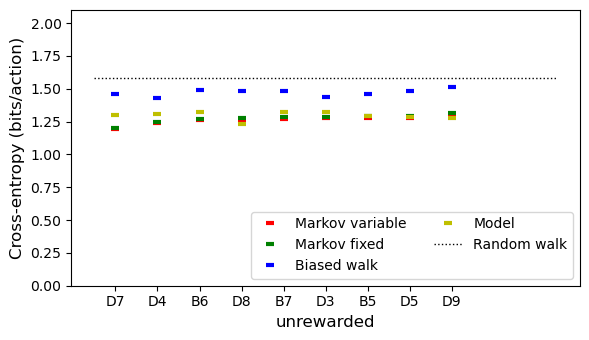

In [33]:
k=len(RewNames)
RN=np.array(RewNames)
UN=np.array(UnrewNamesSub)
ev=np.array(ev);ef=np.array(ef);eb=np.array(eb);en=np.array(en);ace=np.array(all_ce)
evr=ev[:k];efr=ef[:k];ebr=eb[:k];enr=en[:k]
evu=ev[k:];efu=ef[k:];ebu=eb[k:];enu=en[k:];aceu=ace[k:]
sir=np.argsort(evr)
siu=np.argsort(evu)
print('Limited to T-junctions during exploration, includes L vs R node pooling')
ax=plot(np.arange(len(UN)),[evu[siu],efu[siu],ebu[siu],aceu[siu]],
    fmts=['r_','g_','b_','y_'],markersize=6,markeredgewidth=3,
       figsize=(6,3.5),xlabel='unrewarded',ylabel='Cross-entropy (bits/action)');
plot([-0.5,len(UN)+1.5],[np.log(3)/np.log(2),np.log(3)/np.log(2)],
    fmts=['k:'],linewidth=1,ylim=[0,2.1],axes=ax);
plt.legend(['Markov variable','Markov fixed','Biased walk','Model','Random walk'],loc='lower right',ncol=2)
plt.xticks(list(np.arange(len(UN))),list(UN[siu]));

## Calculate cross-entropy between two simulations

In [25]:
eta=0.1
gamma=0.1
beta=600
nbouts=100

# sim 1
E1,policy1,sta = Init(beta)
E1,policy1,hist1 = Simulate(nbouts,E1,policy1,sta,beta,gamma,eta)

# sim 2
E2,policy2,_ = Init(beta)
E2,policy2,hist2 = Simulate(nbouts,E2,policy2,sta,beta,gamma,eta)

print(CalculateCrossEntropy2P(policy1,policy2))
print(CalculateCrossEntropy2P(policy1,policy1))
print(CalculateCrossEntropy2P(policy2,policy2))


0.7974775992492363
0.7815451158666329
0.7778066382473241


In [154]:
print(-np.log2(1/(126*3)))

8.562242424221072
